In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce
import bokeh.palettes

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

eigenvec_df = pd.read_csv("../PCA/eigenvec_500PC.csv", index_col=[0])
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
lineages = pd.read_csv("../lineages/combined_lineages_samples.csv")

print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *
cc_df = pd.read_csv("../data/drug_CC.csv")

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETO",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMK",
                  "Pretomanid": "PMD",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LFX",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

#solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1]).query("tier==1")
drugs_lst = np.sort(os.listdir(analysis_dir))

# do after canetti replacement above because there are commas in them. But keep the canettii samples
single_lineages = lineages.query("~Lineage.str.contains(',')").reset_index(drop=True)
print(single_lineages.shape)

who_variants = pd.read_csv("../results/WHO-catalog-V2-tier1.csv")
results_final = pd.read_csv("../results/Regression_Final_June2024_Tier1.csv")
sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping_20220922.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")

(52567, 10)
(52172, 10)


# Isolate and Variant Counts for each Model (16 drugs x 9 models = 144)

In [14]:
model_name_mapping = {'dropAF_noSyn_unpooled': 'Unpooled,-Silent',
                      'dropAF_noSyn_poolLoF': 'Pooled,-Silent',
                      'dropAF_withSyn_unpooled': 'Unpooled,+Silent'
                     }

pheno_name_mapping = {'BINARY/tiers=1/phenos=WHO': 'WHO',
                      'BINARY/tiers=1/phenos=ALL': 'ALL',
                      'MIC/tiers=1': 'MIC'
                     }

In [2]:
model_sizes = pd.DataFrame(columns = ['Drug', 'Phenotypes', 'Model', 'Isolates', 'Variants'])
i = 0

for drug in drugs_lst:

    if drug != 'Pretomanid':

        for phenos in ['BINARY/tiers=1/phenos=WHO', 'BINARY/tiers=1/phenos=ALL', 'MIC/tiers=1']:
    
            for model in ['dropAF_noSyn_unpooled', 'dropAF_noSyn_poolLoF', 'dropAF_withSyn_unpooled']:
    
                model_fName = os.path.join(analysis_dir, drug, phenos, model, "model_matrix.pkl")

                if os.path.isfile(model_fName):
                    model_matrix = pd.read_pickle(model_fName)
    
                    # if 'withSyn' in model:
                    #     noSyn_model = pd.read_pickle(os.path.join(analysis_dir, drug, phenos, model.replace('withSyn', 'noSyn'), "model_matrix.pkl"))
                    #     num_variants = len(set(model_matrix.columns) - set(noSyn_model.columns))
                    # else:
                    #     num_variants = model_matrix.shape[1]
                    num_variants = model_matrix.shape[1]
                        
                    model_sizes.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], model_matrix.shape[0], num_variants]
                # Pretomanid/ALL models and some pooled models do not exist
                else:
                    model_sizes.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], np.nan, np.nan]
    
                i += 1

# Numbers of Isolates and Variants dropped from each model

In [4]:
isolates_variants_dropped_df = pd.DataFrame(columns = ['Drug', 'Phenotypes', 'Model', 'Isolates_Amb', 'Variants_Amb', 'Isolates_Missing', 'Variants_Missing'])
i = 0

for drug in drugs_lst:

    if drug != 'Pretomanid':

        for phenos in ['BINARY/tiers=1/phenos=WHO', 'BINARY/tiers=1/phenos=ALL', 'MIC/tiers=1']:
    
            for model in ['dropAF_noSyn_unpooled', 'dropAF_noSyn_poolLoF', 'dropAF_withSyn_unpooled']:
    
                if os.path.isdir(os.path.join(analysis_dir, drug, phenos, model)):
                    
                    isolates_missing_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_isolates/isolates_dropped.txt")
                    isolates_amb_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_isolates/isolates_with_amb.txt")
    
                    variants_missing_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_features/isolates_dropped.txt")
                    variants_amb_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_features/isolates_with_amb.txt")
                    
                    if os.path.isfile(isolates_missing_fName):
                        num_isolates_missing = len(pd.read_csv(isolates_missing_fName, sep='\t', header=None))
                    else:
                        num_isolates_missing = 0
        
                    if os.path.isfile(isolates_amb_fName):
                        num_isolates_amb = len(pd.read_csv(isolates_amb_fName, sep='\t', header=None))
                    else:
                        num_isolates_amb = 0
    
                    if os.path.isfile(variants_missing_fName):
                        num_variants_missing = len(pd.read_csv(variants_missing_fName, sep='\t', header=None))
                    else:
                        num_variants_missing = 0
        
                    if os.path.isfile(variants_amb_fName):
                        num_variants_amb = len(pd.read_csv(variants_amb_fName, sep='\t', header=None))
                    else:
                        num_variants_amb = 0
    
                    isolates_variants_dropped_df.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], num_isolates_amb, num_variants_amb, num_isolates_missing, num_variants_missing]
                    
                else:
                    isolates_variants_dropped_df.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], np.nan, np.nan, np.nan, np.nan]
    
                i += 1

In [5]:
len(isolates_variants_dropped_df), len(model_sizes)

(135, 135)

In [14]:
df_combined_counts = isolates_variants_dropped_df.merge(model_sizes, on=['Drug', 'Phenotypes', 'Model'])
df_combined_counts = df_combined_counts.sort_values(['Drug', 'Phenotypes'], ascending=[True, False])

In [4]:
df_combined_counts['Isolates'].min(), df_combined_counts['Isolates'].max()

(560.0, 48236.0)

In [5]:
df_combined_counts['Variants'].min(), df_combined_counts['Variants'].max()

(31.0, 4086.0)

# Overlap between MIC and WHO datasets

In [106]:
WHO_dataset_overlap = pd.DataFrame(columns=['Drug', 'Phenotypes', 'Model', 'Isolates', 'WHO_Overlap'])
i = 0

for drug in drugs_lst:

    if drug != 'Pretomanid':
            
        for phenos in ['BINARY/tiers=1/phenos=WHO', 'BINARY/tiers=1/phenos=ALL', 'MIC/tiers=1']:

            for model in ['dropAF_noSyn_unpooled', 'dropAF_noSyn_poolLoF', 'dropAF_withSyn_unpooled']:
                
                if os.path.isdir(os.path.join(analysis_dir, drug, phenos, model)):
                    
                    WHO_isolates = set(pd.read_pickle(os.path.join(analysis_dir, drug, 'BINARY/tiers=1/phenos=WHO', model, 'model_matrix.pkl')).index.values)
    
                    isolates_lst = set(pd.read_pickle(os.path.join(analysis_dir, drug, phenos, model, 'model_matrix.pkl')).index.values)
    
                    WHO_dataset_overlap.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], len(isolates_lst), len(set(WHO_isolates).intersection(isolates_lst))]
    
                else:
                     WHO_dataset_overlap.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], np.nan, np.nan]
                    
                i += 1

In [114]:
df_combined_counts = df_combined_counts.merge(WHO_dataset_overlap, on=['Drug', 'Phenotypes', 'Model', 'Isolates'], how='outer')

# 100% overlap between MIC dataset and itself
df_combined_counts.loc[df_combined_counts['Phenotypes']=='WHO', 'WHO_Overlap'] = df_combined_counts.loc[df_combined_counts['Phenotypes']=='WHO']['Isolates']

df_combined_counts['WHO_Overlap_Prop'] = df_combined_counts['WHO_Overlap'] / df_combined_counts['Isolates']

# df_combined_counts.to_csv("../tables/model_sizes_with_dropped_counts.csv", index=False)

In [119]:
# what proportion of the MIC dataset is in the WHO dataset?
df_combined_counts.query("Phenotypes=='MIC'")['WHO_Overlap_Prop'].min(), df_combined_counts.query("Phenotypes=='MIC'")['WHO_Overlap_Prop'].max()

(0.0, 0.15380956156346626)

In [122]:
df_combined_counts.query("Drug=='Bedaquiline' & Phenotypes=='MIC'")

,Drug,Phenotypes,Model,Isolates_Amb,Variants_Amb,Isolates_Missing,Variants_Missing,Isolates,Variants,WHO_Overlap,WHO_Overlap_Prop
12,Bedaquiline,MIC,"Unpooled,-Silent",189.0,0.0,32.0,55.0,12367.0,552.0,548,0.044311
13,Bedaquiline,MIC,"Pooled,-Silent",188.0,0.0,32.0,49.0,12368.0,467.0,548,0.044308
14,Bedaquiline,MIC,"Unpooled,+Silent",205.0,2.0,33.0,79.0,12350.0,733.0,548,0.044372


# 0. Correlations Between Lineages and Each PC

In [3]:
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                   "M.bovis": "gray",
                   "M.canettii": "black"
                  }

def plot_PCA_colored_by_lineage(lineage_df, eigenvec_df, pc_x, pc_y, include_lineages=None, color_col="Lineage", legend_out=False, color_dict=None, saveName=None):
    
    if include_lineages is None:

        color_col = "Lineage"
        color_dict = LinToColor_Dict
        
        # combine BOV and BOV_AFRI into a single group for plotting purposes
        lineage_df.loc[lineage_df[color_col].isin(['BOV', 'BOV_AFRI']), color_col] = 'M.bovis'
        lineage_df.loc[lineage_df[color_col].isin(['canettii']), color_col] = 'M.canettii'

        # order in reverse order so that L1 is plotted on top (not behind bovis and canettii)
        lineage_df = lineage_df.sort_values(color_col, ascending=False)
        
        include_lineages = lineage_df[color_col].unique()
        
    else:
        color_dict = None

        # order in ascending order so that sublineages are ordered and easy to read
        lineage_df = lineage_df.sort_values(color_col, ascending=True)
        
    plot_df = lineage_df.query("Lineage in @include_lineages").merge(eigenvec_df, left_on="Sample_ID", right_index=True, how="inner")        

    fig, ax = plt.subplots(figsize=(5, 4))
    
    if color_dict is not None:
        
        # plot_df_downsampled = []

        # for single_lineage in plot_df['Lineage'].unique():
        
        #     # keep 10% of each lineage. But get the numbers first for the rare lineages that have fewer than 0.1N
        #     keep_num = int(np.ceil(len(plot_df.query("Lineage==@single_lineage")) * 0.1))
        #     single_lineage_df = plot_df.query("Lineage==@single_lineage").reset_index().sample(n=keep_num, replace=False)
        
        #     plot_df_downsampled.append(single_lineage_df)
        
        # plot_df_downsampled = pd.concat(plot_df_downsampled)
        # assert len(plot_df_downsampled) == plot_df_downsampled.Sample_ID.nunique()
    
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        hue_order=np.sort(include_lineages),
                        palette=color_dict,
                        alpha=0.8,
                        s=30,
                        ax=ax
                        )
        
    else:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        palette='husl', #Category20[20],
                        alpha=0.8,
                        s=30,
                        ax=ax
                        )

    # plt.title(f"{plot_df.Sample_ID.nunique()} Isolates")
    print(f"{plot_df.Sample_ID.nunique()} Isolates")
    
    if legend_out:
        sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))
    else:
        sns.move_legend(ax, fontsize=8, title='', loc='best')

    # for lh in ax._legend.legendHandles: 
    #     lh._sizes = [10] 
    #     # You can also use lh.set_sizes([50])

    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=600, bbox_inches="tight")

In [4]:
scaler = StandardScaler()

combined_single_lineage_PC = pd.get_dummies(single_lineages.set_index("Sample_ID")["Lineage"]).astype(int).merge(eigenvec_df, left_index=True, right_index=True)

def get_lineage_correlations_with_PC(lineage, sig_thresh=0.01):

    single_lineage_pvals = pd.DataFrame(columns=["rho", "pval", "PC", "abs_rho"])
    
    for i, col in enumerate(combined_single_lineage_PC.columns[combined_single_lineage_PC.columns.str.contains("PC")]):
    
        # rho, pval = st.pointbiserialr(combined_single_lineage_PC[lineage].values, combined_single_lineage_PC[col].values)
        rho, pval = st.pearsonr(np.squeeze(scaler.fit_transform(combined_single_lineage_PC[lineage].values.reshape(-1, 1))), 
                                combined_single_lineage_PC[col].values
                               )
        
        single_lineage_pvals.loc[i, :] = [rho, pval, int(col.replace("PC", "")), np.abs(rho)]
    
    single_lineage_pvals["Bonferroni_pval"] = np.min([single_lineage_pvals["pval"] * len(single_lineage_pvals), np.ones(len(single_lineage_pvals))], axis=0)
    return single_lineage_pvals.query("Bonferroni_pval < @sig_thresh").sort_values("abs_rho", ascending=False)

In [5]:
lineage_corr_dict = {}

for lineage in np.sort(single_lineages.Lineage.unique()):

    num_lineage = len(single_lineages.query("Lineage==@lineage"))
    
    if num_lineage / len(single_lineages) >= 0.005:
        lineage_corr_dict[lineage] = get_lineage_correlations_with_PC(lineage)

In [19]:
lineage_corr_dict['2']

,rho,pval,PC,abs_rho,Bonferroni_pval
1,-0.883063,0.0,2,0.883063,0.0
0,-0.356028,0.0,1,0.356028,0.0
2,-0.280158,0.0,3,0.280158,0.0
8,0.043782,0.0,9,0.043782,0.0
18,-0.039048,0.0,19,0.039048,0.0
42,-0.030527,0.0,43,0.030527,0.0
19,0.025172,0.0,20,0.025172,0.000004
33,-0.024512,0.0,34,0.024512,0.000011
34,-0.023637,0.0,35,0.023637,0.000033
59,-0.022027,0.0,60,0.022027,0.000243


In [6]:
plot_df = single_lineages.merge(eigenvec_df, left_on="Sample_ID", right_index=True, how="inner")

In [7]:
# plot_df.drop_duplicates(subset=['PC1', 'PC2'])

52172 Isolates


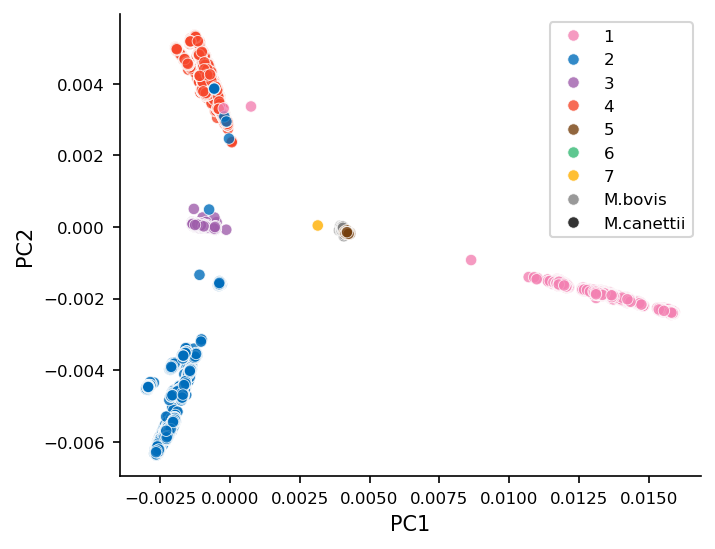

In [7]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC1', pc_y='PC2', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC1_PC2.png'
                           )

52172 Isolates


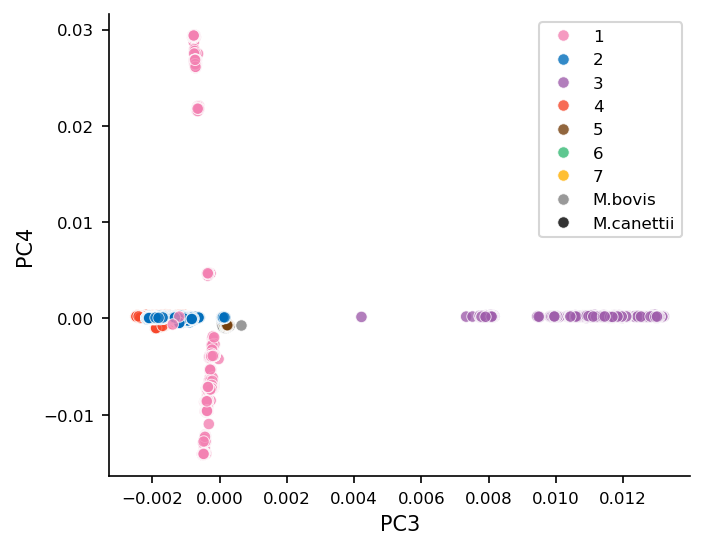

In [8]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC3', pc_y='PC4', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC3_PC4.png'
                           )

52172 Isolates


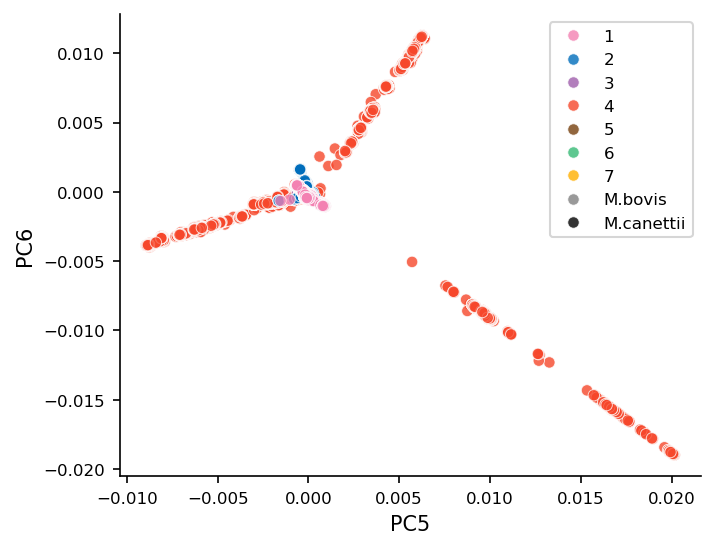

In [11]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC5', pc_y='PC6', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC5_PC6.png'
                           )

52172 Isolates


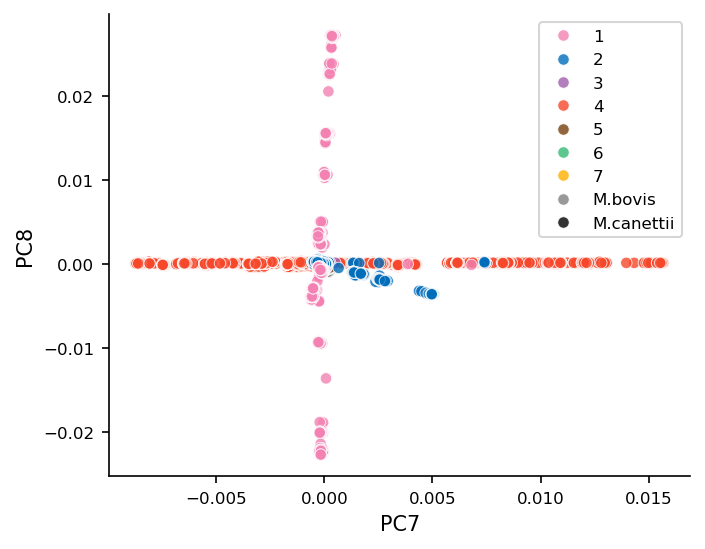

In [37]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC7', pc_y='PC8', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            #saveName='../PCA/PC7_PC8.png'
                           )

52172 Isolates


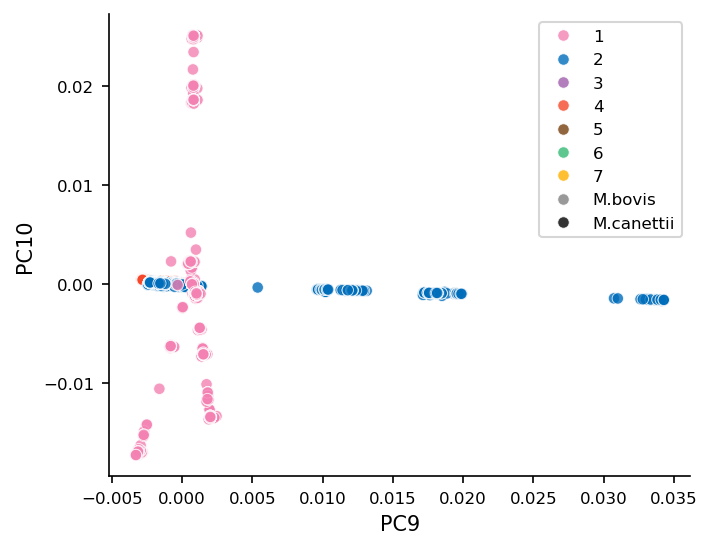

In [13]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC9', pc_y='PC10', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC9_PC10.png'
                           )

16801 Isolates


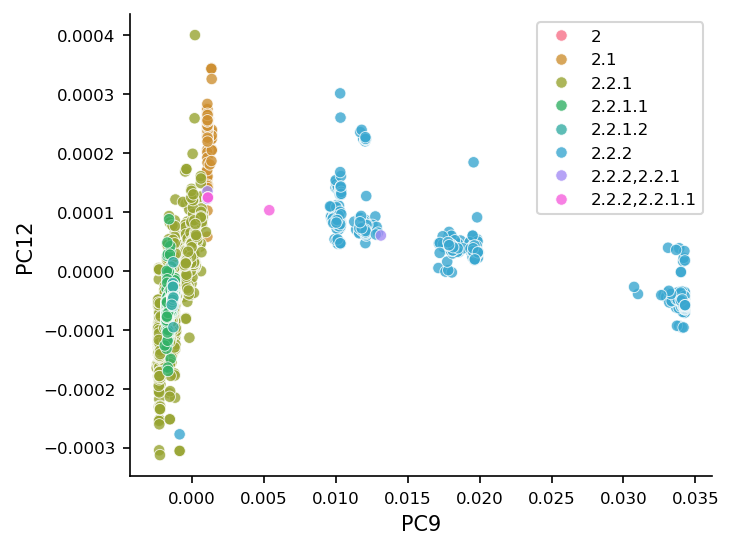

In [25]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC9', pc_y='PC12', 
                            include_lineages=["2"],
                            color_col="Coll2014", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC9_PC12_L2.png'
                           )

4607 Isolates


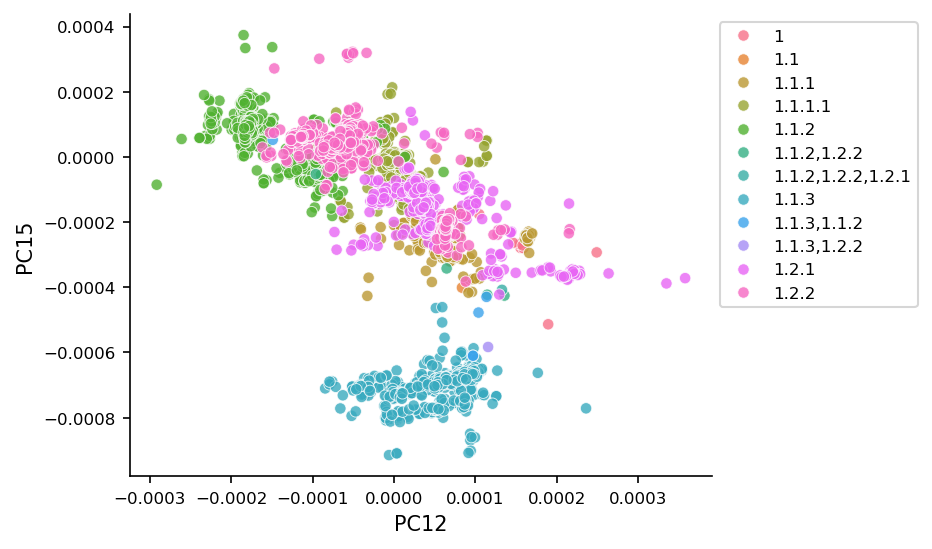

In [26]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC12', pc_y='PC15', 
                            include_lineages=["1"],
                            color_col="Coll2014", 
                            legend_out=True,
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC12_PC15_L1.png'
                           )

# Plot Sublineages of L4 that Comprise at least 2% of the Dataset

In [27]:
L4_samples = single_lineages.merge(eigenvec_df, left_on='Sample_ID', right_index=True).dropna(subset="Coll2014").query("Lineage=='4' & ~Coll2014.str.contains(',')")

L4_samples['L4_sublineage_level1'] = ['.'.join(val.split('.')[:2]) for val in L4_samples.Coll2014.values]
print(len(L4_samples))

thresh = int(len(L4_samples) / 50)

# plot only lineages that make up at least 2% of the dataset
include_lineages = pd.DataFrame(L4_samples['Coll2014'].value_counts()).query("count >= @thresh").index.values

24149


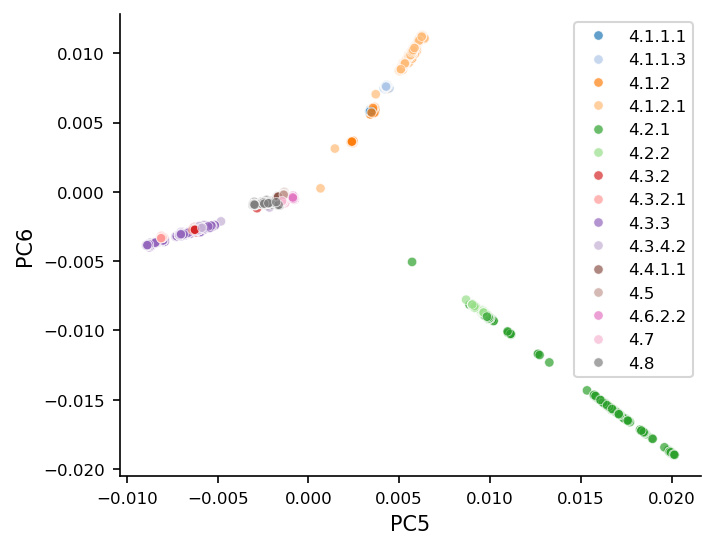

In [36]:
pc_x = 'PC5'
pc_y = 'PC6'
color_col = 'Coll2014'

fig, ax = plt.subplots(figsize=(5, 4))

L4_samples = L4_samples.query("Coll2014 in @include_lineages")

sns.scatterplot(data=L4_samples,
                x=pc_x,
                y=pc_y,
                hue=color_col,
                hue_order=np.unique(L4_samples[color_col]),
                palette=bokeh.palettes.Category20[L4_samples[color_col].nunique()],
                alpha=0.7,
                s=20,
                ax=ax
                )

sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))

# for lh in ax._legend.legendHandles: 
#     lh._sizes = [10] 
#     # You can also use lh.set_sizes([50])

ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()
plt.show()

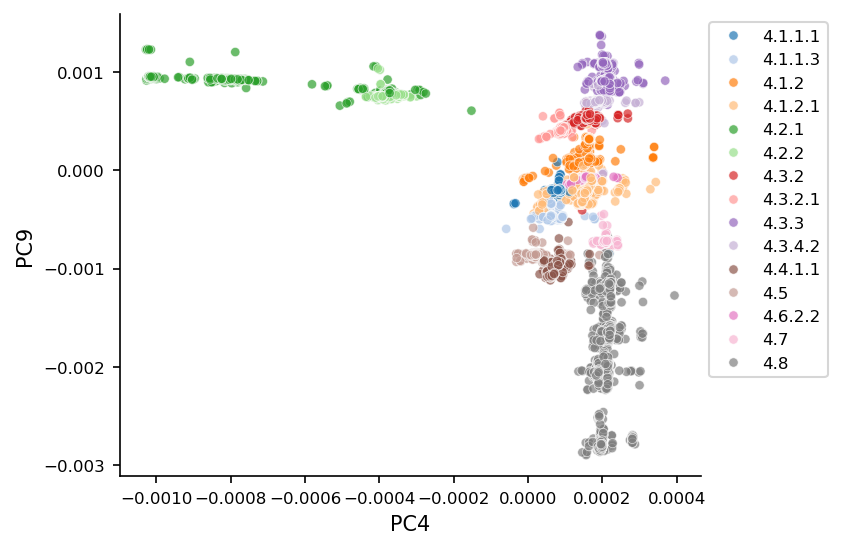

In [33]:
pc_x = 'PC4'
pc_y = 'PC9'
color_col = 'Coll2014'

fig, ax = plt.subplots(figsize=(5, 4))

L4_samples = L4_samples.query("Coll2014 in @include_lineages")

sns.scatterplot(data=L4_samples,
                x=pc_x,
                y=pc_y,
                hue=color_col,
                hue_order=np.unique(L4_samples[color_col]),
                palette=bokeh.palettes.Category20[L4_samples[color_col].nunique()],
                alpha=0.7,
                s=20,
                ax=ax
                )

sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))

# for lh in ax._legend.legendHandles: 
#     lh._sizes = [10] 
#     # You can also use lh.set_sizes([50])

ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()
plt.savefig(f"../PCA/{pc_x}_{pc_y}_L4_thresh2percent.png", bbox_inches='tight', dpi=600)

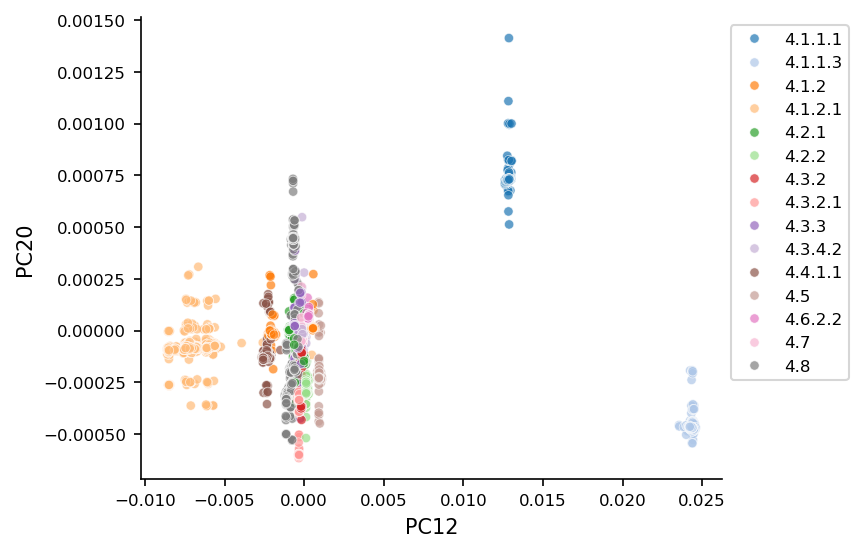

In [31]:
pc_x = 'PC12'
pc_y = 'PC20'
color_col = 'Coll2014'

fig, ax = plt.subplots(figsize=(5, 4))

L4_samples = L4_samples.query("Coll2014 in @include_lineages")

sns.scatterplot(data=L4_samples,
                x=pc_x,
                y=pc_y,
                hue=color_col,
                hue_order=np.unique(L4_samples[color_col]),
                palette=bokeh.palettes.Category20[L4_samples[color_col].nunique()],
                alpha=0.7,
                s=20,
                ax=ax
                )

sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))

# for lh in ax._legend.legendHandles: 
#     lh._sizes = [10] 
#     # You can also use lh.set_sizes([50])

ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()
plt.show()
#plt.savefig(f"../PCA/{pc_x}_{pc_y}_L4_thresh2percent.png", bbox_inches='tight', dpi=600)

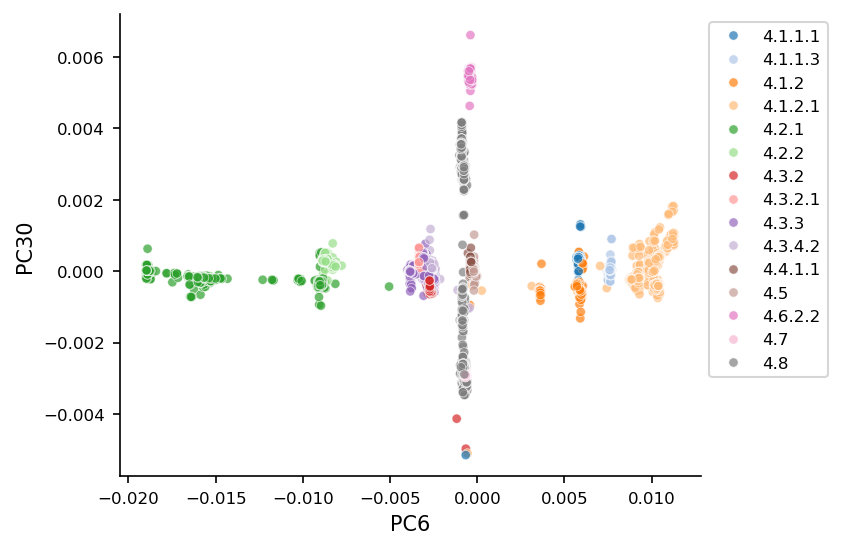

In [35]:
pc_x = 'PC6'
pc_y = 'PC30'
color_col = 'Coll2014'

fig, ax = plt.subplots(figsize=(5, 4))

L4_samples = L4_samples.query("Coll2014 in @include_lineages")

sns.scatterplot(data=L4_samples,
                x=pc_x,
                y=pc_y,
                hue=color_col,
                hue_order=np.unique(L4_samples[color_col]),
                palette=bokeh.palettes.Category20[L4_samples[color_col].nunique()],
                alpha=0.7,
                s=20,
                ax=ax
                )

sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))

# for lh in ax._legend.legendHandles: 
#     lh._sizes = [10] 
#     # You can also use lh.set_sizes([50])

ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()
plt.savefig(f"../PCA/{pc_x}_{pc_y}_L4_thresh2percent.png", bbox_inches='tight', dpi=600)

# 1. Numbers of Isolates and Variants in Each Model

In [367]:
summary_df = pd.DataFrame(columns = ['Drug', 'WHO_Isolates_Base', 'WHO_Unpooled_Variants', 'WHO_Pooled_Variants', 'WHO_Silent_Only', 'ALL_Isolates_Base', 'ALL_Unpooled_Variants', 'ALL_Pooled_Variants', 'ALL_Silent_Only'])
i = 0

for drug in drugs_lst:

    who_nonsilent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
    
    try:
        who_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_noSyn_poolSeparate", "model_matrix.pkl"))
    except:
        who_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
    
    who_silent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_withSyn_unpooled", "model_matrix.pkl"))

    who_silent_variants = set(who_silent.columns) - set(who_nonsilent.columns)
    
    if drug != 'Pretomanid':
        all_nonsilent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
        
        try:
            all_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_noSyn_poolSeparate", "model_matrix.pkl"))
        except:
            all_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
        
        all_silent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_withSyn_unpooled", "model_matrix.pkl"))
        
    else:
        all_nonsilent = pd.DataFrame()
        all_nonsilent_pooled = pd.DataFrame()
        all_silent = pd.DataFrame()

    all_silent_variants = set(all_silent.columns) - set(all_nonsilent.columns)

    summary_df.loc[i, :] = [drug, who_nonsilent.shape[0], who_nonsilent.shape[1], who_nonsilent_pooled.shape[1], len(who_silent_variants),
                            all_nonsilent.shape[0], all_nonsilent.shape[1], all_nonsilent_pooled.shape[1], len(all_silent_variants)]
    i += 1

summary_df = summary_df.sort_values("Drug", ascending=True).reset_index(drop=True)
summary_df.to_csv("../tables/Table_S1.csv", index=False)

# 2. Numbers of R and S Isolates in each Model

In [25]:
def compute_number_of_isolates_per_model(drug, phenos_name, tiers_lst):

    fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
    
    if os.path.isfile(fName):
        model_matrix = pd.read_pickle(fName)

        samples = model_matrix.index.values
        del model_matrix

        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).query("sample_id in @samples")    
        return len(df_phenos.query("phenotype==1")), len(df_phenos.query("phenotype==0"))
    else:
        return np.nan, np.nan

In [26]:
RS_counts = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):

    if drug != 'Pretomanid':
        num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1"])
        num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1"])
        
        RS_counts.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

# Calculate percentages for stacking
RS_counts['WHO_Percent_R'] = RS_counts['WHO_Num_R'] / (RS_counts['WHO_Num_R'] + RS_counts['WHO_Num_S']) * 100
RS_counts['WHO_Percent_S'] = RS_counts['WHO_Num_S'] / (RS_counts['WHO_Num_R'] + RS_counts['WHO_Num_S']) * 100

RS_counts['ALL_Percent_R'] = RS_counts['ALL_Num_R'] / (RS_counts['ALL_Num_R'] + RS_counts['ALL_Num_S']) * 100
RS_counts['ALL_Percent_S'] = RS_counts['ALL_Num_S'] / (RS_counts['ALL_Num_R'] + RS_counts['ALL_Num_S']) * 100

RS_counts.to_csv("../tables/RS_counts_models.csv", index=False)

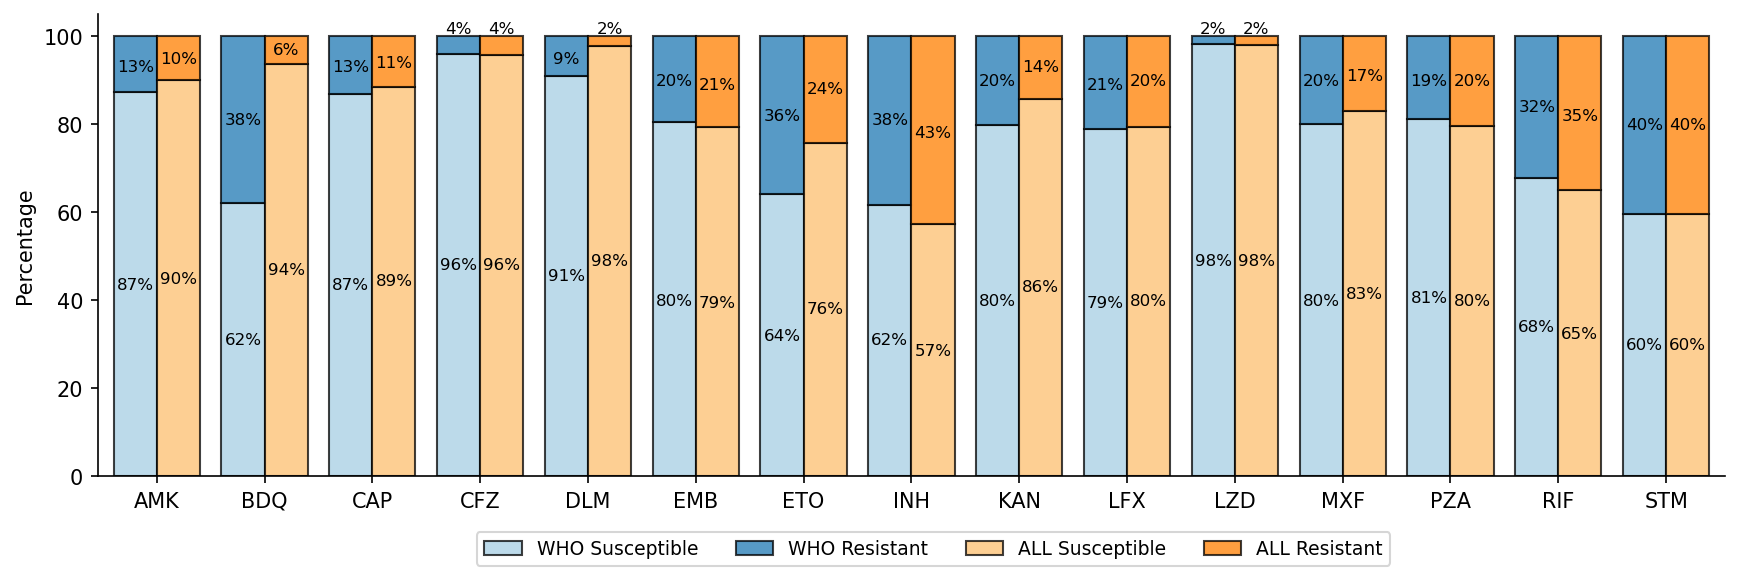

In [34]:
# Plotting
bar_width=0.4
fig, ax = plt.subplots(figsize=(14, 4))
colors = sns.color_palette('Paired').as_hex()[:2] + sns.color_palette('Paired')[6:8]

ax.bar(np.arange(len(RS_counts['Drug'])) - bar_width/2, RS_counts['WHO_Percent_S'], label='WHO Susceptible', width=bar_width, color=colors[0], edgecolor='black', alpha=0.75)
ax.bar(np.arange(len(RS_counts['Drug'])) - bar_width/2, RS_counts['WHO_Percent_R'], label='WHO Resistant', bottom=RS_counts['WHO_Percent_S'], width=bar_width, color=colors[1], edgecolor='black', alpha=0.75)

ax.bar(np.arange(len(RS_counts['Drug'])) + bar_width/2, RS_counts['ALL_Percent_S'], label='ALL Susceptible', width=bar_width, color=colors[2], edgecolor='black', alpha=0.75)
ax.bar(np.arange(len(RS_counts['Drug'])) + bar_width/2, RS_counts['ALL_Percent_R'], label='ALL Resistant', bottom=RS_counts['ALL_Percent_S'], width=bar_width, color=colors[3], edgecolor='black', alpha=0.75)

# Add labels to each bar
for drug in RS_counts['Drug']:

    plot_vals = RS_counts.loc[RS_counts['Drug']==drug, ['WHO_Percent_S', 'WHO_Percent_R', 'ALL_Percent_S', 'ALL_Percent_R']]
    
    for col in plot_vals.columns:
        
        if 'WHO' in col:
            x_pos = list(RS_counts['Drug']).index(drug) - bar_width/2
            
        else:
            x_pos = list(RS_counts['Drug']).index(drug) + bar_width/2

        val = int(np.round(plot_vals[col].values[0], 0))

        if not pd.isnull(val):

            associated_count = RS_counts.set_index('Drug').loc[drug, col.replace('Percent', 'Num')]
            # combined_text = f"{val}%\n({'{:,.0f}'.format(associated_count)})"
            combined_text = f"{val}%"

            if 'S' in col:
                y_pos = val / 2
            else:
                y_pos = int((100 - val) + val / 2)

            # small numbers for which the bars are too short to accommodate the whole number, put on top
            if val < 5:                
                ax.text(x_pos, 100, combined_text, ha='center', va='bottom', fontsize='8')
            else:
                ax.text(x_pos, y_pos, combined_text, ha='center', va='center', fontsize='8')

ax.set_xticks(ticks=np.arange(len(RS_counts['Drug'])), labels=[drug_abbr_dict[drug] for drug in RS_counts['Drug']])
ax.set_ylabel('Percentage')
# ax.set_title('Phenotypes of Regression Model Isolates')
sns.despine()
ax.legend()
ax.margins(x=0.01)
sns.move_legend(ax, ncols=4, fontsize=9, title='', loc='best', bbox_to_anchor=(0.8, -0.1))
plt.savefig("../results/Figures/phenos_breakdown.svg", bbox_inches='tight', format='svg')

# 3. Lineage Breakdown for Each Drug

In [28]:
def create_lineage_summary_df(og_lineages_df, other_thresh=0.01):
    '''
    other_cols is a list of lineages that should be combined into an other category because there are so few of them. Basically just for aesthetic purposes
    '''
    
    lineage_summary = pd.DataFrame(og_lineages_df["Lineage"].value_counts()).reset_index()
    
    # get lineages that are present at < 1% frequency. Combine them into an "Other" category for aesthetic purposes in plotting
    samples_total = lineage_summary["count"].sum()
    samples_thresh = int(other_thresh*samples_total)
    other_cols = lineage_summary.query("count < @samples_thresh")["Lineage"].values
    
    # ",".join(other_cols) --> this makes the name too long, but can try later
    # combine low-frequency lineages into an Other category
    lineage_summary = pd.concat([lineage_summary, 
                                 pd.DataFrame({"Lineage": "Other", "count": lineage_summary.query("Lineage in @other_cols")["count"].sum()
                                              }, index=[-1])
                                ]).query("Lineage not in @other_cols")
    
    lineage_summary = lineage_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    lineage_summary["count"] = lineage_summary["count"].astype(int)
    return lineage_summary

In [29]:
def compute_number_of_lineages_per_model(drugs_lst, lineages_df):
    
    lineage_summaries_by_drug = []
    
    for drug in drugs_lst:

        if drug != 'Pretomanid':
            fName = os.path.join(analysis_dir, drug, "BINARY", "tiers=1/phenos=ALL", "dropAF_noSyn_unpooled/model_matrix.pkl")
        else:
            fName = os.path.join(analysis_dir, drug, "BINARY", "tiers=1/phenos=WHO", "dropAF_noSyn_unpooled/model_matrix.pkl")
        
        model_matrix = pd.read_pickle(fName)
        samples = model_matrix.index.values
    
        single_drug_lineage_summary = create_lineage_summary_df(lineages_df.query("Sample_ID in @samples"), other_thresh=0.01)
        single_drug_lineage_summary["Drug"] = drug_abbr_dict[drug]

        lineage_summaries_by_drug.append(single_drug_lineage_summary)
    
    return pd.concat(lineage_summaries_by_drug, axis=0)

In [30]:
single_drug_lineage_summary = compute_number_of_lineages_per_model(os.listdir(analysis_dir), single_lineages)
single_drug_lineage_summary

,Lineage,count,Drug
0,1,1230,AMK
1,2,9174,AMK
2,3,2085,AMK
3,4,10885,AMK
4,Other,52,AMK
...,...,...,...
0,1,2013,STM
1,2,8718,STM
2,3,1638,STM
3,4,11672,STM


In [31]:
def create_stacked_percent_bar_chart(df, xvar, quantVar, hueVar, saveName=None):
    
    LinToColor_Dict = {"1": "#f381b2",
                       "2": "#006dbb",
                       "3": "#9f5eab",
                       "4": "#f6472b",
                       "5": "#76400e",
                       "Other": "white"
                      }
    
    # set the figure size
    fig, ax = plt.subplots(figsize=(12, 4))
    font_size = '7'
    
    df = df.query("Drug != 'PMD'")

    lineage_stacked_for_plotting_counts = df.pivot(index="Drug", columns="Lineage", values="count")
    lineage_stacked_for_plotting_counts["Total"] = lineage_stacked_for_plotting_counts.sum(axis=1)
    lineage_stacked_for_plotting_counts = lineage_stacked_for_plotting_counts.fillna(0)
    lineage_stacked_for_plotting = lineage_stacked_for_plotting_counts.copy()

    # compute proportions for plotting
    for lineage in df["Lineage"].unique():
        lineage_stacked_for_plotting[lineage] = lineage_stacked_for_plotting[lineage] / lineage_stacked_for_plotting["Total"] * 100
        
    del lineage_stacked_for_plotting["Total"]
        
    # keep track of all the groups to increase the start value of the next bar
    prev_vals_array = np.zeros(len(lineage_stacked_for_plotting))

    # reverse order of the numerical lineages so that L1 is at the top and L4 is at the bottom
    # need to put non-numerical lineages at the end (after L1) to be at the top
    color_groups = np.concatenate([np.sort([col for col in lineage_stacked_for_plotting.columns if col.isnumeric()])[::-1], [col for col in lineage_stacked_for_plotting.columns if not col.isnumeric()]])

    # reorder the dataframes to that order too
    lineage_stacked_for_plotting = lineage_stacked_for_plotting[color_groups]
    lineage_stacked_for_plotting_counts = lineage_stacked_for_plotting_counts[color_groups]
    
    drugs_lst = lineage_stacked_for_plotting_counts.index.values
    
    for i, color_group in enumerate(color_groups):        

        ax.bar(x=drugs_lst,
               height=lineage_stacked_for_plotting.loc[:, color_group],
               color=LinToColor_Dict[color_group], 
               bottom=prev_vals_array,
               edgecolor="black",
               label=color_group,
               alpha=0.75,
              )

        prev_vals_array += lineage_stacked_for_plotting.loc[:, color_group]

        # annotate with percentage and counts
        for drug in drugs_lst:

            val = int(np.round(lineage_stacked_for_plotting.loc[drug, color_group], 0))

            if val > 2:
    
                # top of the current box
                y_upper = lineage_stacked_for_plotting.loc[drug, lineage_stacked_for_plotting.columns[:i+1]].values.sum()
                
                # bottom of the current box
                y_lower = lineage_stacked_for_plotting.loc[drug, lineage_stacked_for_plotting.columns[:i]].values.sum()
                
                y_pos = np.mean([y_lower, y_upper])
            
                # format the isolate counts with commas and don't include any decimal places
                comma_format = '{:,.0f}'.format(lineage_stacked_for_plotting_counts.loc[drug, color_group])
                combined_text = f"{val}%\n({comma_format})"
                # ax.text(drug, y_pos, combined_text, ha='center', va='center', fontsize=font_size)
                
                # small numbers for which the bars are too short to accommodate the whole number, put on top
                if val < 7:
    
                    # top bar: make y_pos = 100
                    if i in [lineage_stacked_for_plotting.shape[1] - 1, lineage_stacked_for_plotting.shape[1] - 2]:
                        ax.text(drug, 100, combined_text, ha='center', va='bottom', fontsize=font_size)
                    # bottom bar: make y_pos = 0
                    elif i == 0:
                        ax.text(drug, 0, combined_text, ha='center', va='bottom', fontsize=font_size)
                    # else, idk
                    else:
                        ax.text(drug, y_pos, combined_text, ha='center', va='bottom', fontsize=font_size)
                else:
                    ax.text(drug, y_pos, combined_text, ha='center', va='center', fontsize=font_size)

    plt.setp(ax.patches, linewidth=0.75)
    sns.despine()
    
    # bar_scale = 0.85
    # for patch in ax.patches:
    #     current_width = patch.get_width()
    #     patch.set_width(current_width * bar_scale)
    
    # Rearrange the handles and labels
    handles, labels = ax.get_legend_handles_labels()    
    handles_labels_dict = dict(zip(labels, handles))
    handles_labels_dict = collections.OrderedDict(sorted(handles_labels_dict.items()))

    # Create the legend with the rearranged handles and labels
    ax.legend(list(handles_labels_dict.values()), list(handles_labels_dict.keys()))
    sns.move_legend(ax, fontsize=8, title='Lineage', loc='upper right', #bbox_to_anchor=(1.05, 0.65),
                    ncol=len(color_groups),
                    title_fontsize='9',
                   bbox_to_anchor=(0.65, -0.1))

    ax.margins(x=0.01)
    ax.set_ylabel("Percentage")
    
    if saveName is not None:
        plt.savefig(saveName, bbox_inches='tight', format='svg')
    else:
        plt.show()

    return lineage_stacked_for_plotting

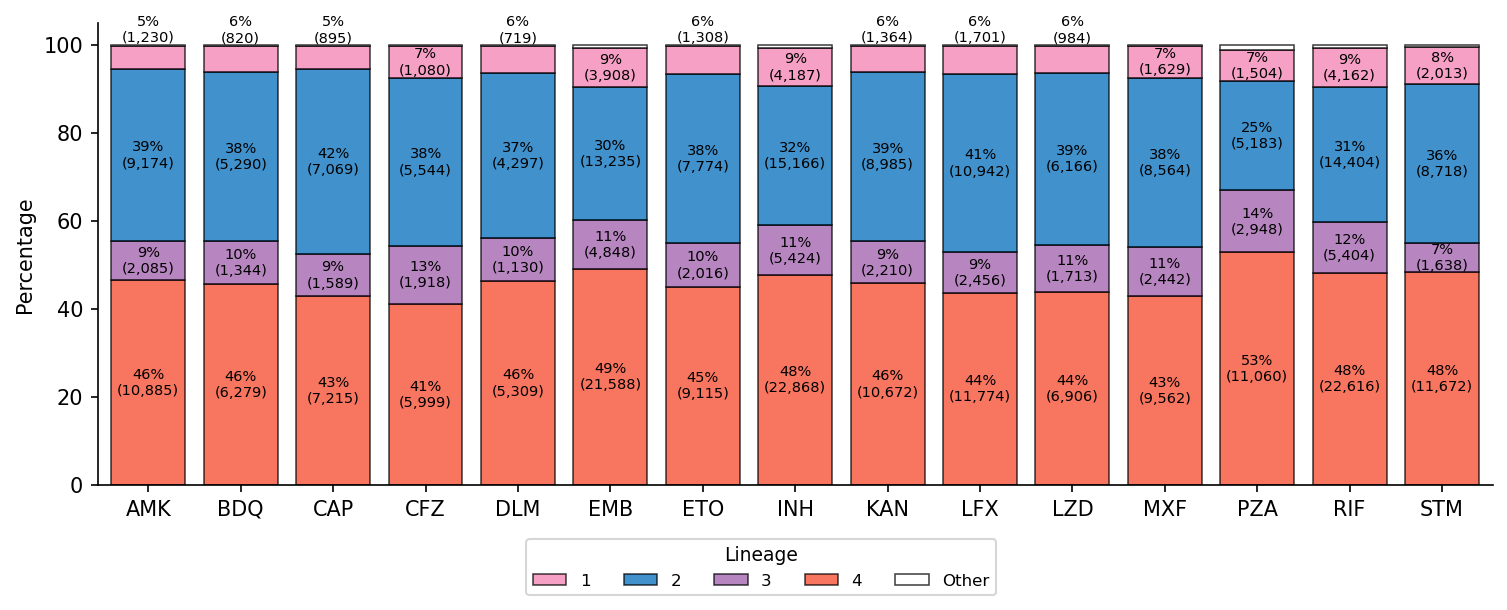

In [32]:
lineage_stacked_for_plotting = create_stacked_percent_bar_chart(single_drug_lineage_summary, "Drug", "Count", "Lineage", saveName="../results/Figures/isolates_by_lineage_stacked_bar.svg")

# Overlap between WHO, ALL, and MIC datasets

## WHO and MIC are disjoint, but some samples have both MICs and pDST measured

## MIC is a subset of the ALL data, but not everything in it

In [3]:
# samples_summary_for_plotting = pd.DataFrame(columns = ['Drug', 'ALL_Phenos', 'WHO_Phenos', 'ALL_Only', 'MIC', 'MIC_Only', 'ALL_MIC', 'Total']).set_index('Drug')

# for drug in drugs_lst:

#     df_mic = pd.concat([pd.read_csv(fName) for fName in glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue-raw-data/mic/drug_name={drug}/*")])
#     df_phenos = pd.concat([pd.read_csv(fName) for fName in glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue-raw-data/phenotypes/drug_name={drug}/*")])

#     samples_summary_for_plotting.loc[drug, :] = [df_phenos.query("phenotypic_category in ['ALL', 'WHO']").sample_id.nunique(),
#                                                  df_phenos.query("phenotypic_category=='WHO'").sample_id.nunique(),
#                                                  df_phenos.query("phenotypic_category=='ALL'").sample_id.nunique(),
#                                                  df_mic.sample_id.nunique(),
#                                                  len(set(df_mic.sample_id) - set(df_phenos.sample_id)), # in the MIC dataset, but not in the binary dataset
#                                                  df_phenos.query("phenotypic_category=='ALL' & box in ['CRyPTIC_MIC', 'MYCOTB_MIC']").sample_id.nunique(),
#                                                  len(set(df_mic.sample_id).union(df_phenos.sample_id))
#                                    ]

# samples_summary_for_plotting = samples_summary_for_plotting.drop('Pretomanid')

# samples_summary_for_plotting['ALL_not_MIC'] = samples_summary_for_plotting['ALL_Only'] - samples_summary_for_plotting['ALL_MIC']

# del samples_summary_for_plotting['ALL_Phenos']
# del samples_summary_for_plotting['MIC']
# del samples_summary_for_plotting['ALL_Only']

# # check that the computed Total is the sum as the number of unique samples from the dataframes
# assert sum(samples_summary_for_plotting[samples_summary_for_plotting.columns[samples_summary_for_plotting.columns != 'Total']].sum(axis=1).values != samples_summary_for_plotting['Total']) == 0

# # convert to percentages
# samples_summary_for_plotting_percent = samples_summary_for_plotting.copy()

# for col in samples_summary_for_plotting_percent.columns:
#     if col != 'Total':
#         samples_summary_for_plotting_percent[col] = samples_summary_for_plotting_percent[col] / samples_summary_for_plotting_percent['Total'] * 100

# del samples_summary_for_plotting_percent['Total']

# # don't need to plot the samples that are only in the MIC dataset
# del samples_summary_for_plotting_percent['MIC_Only']
# samples_summary_for_plotting_percent.to_csv("../tables/ALL_phenos_breakdown_percents.csv")

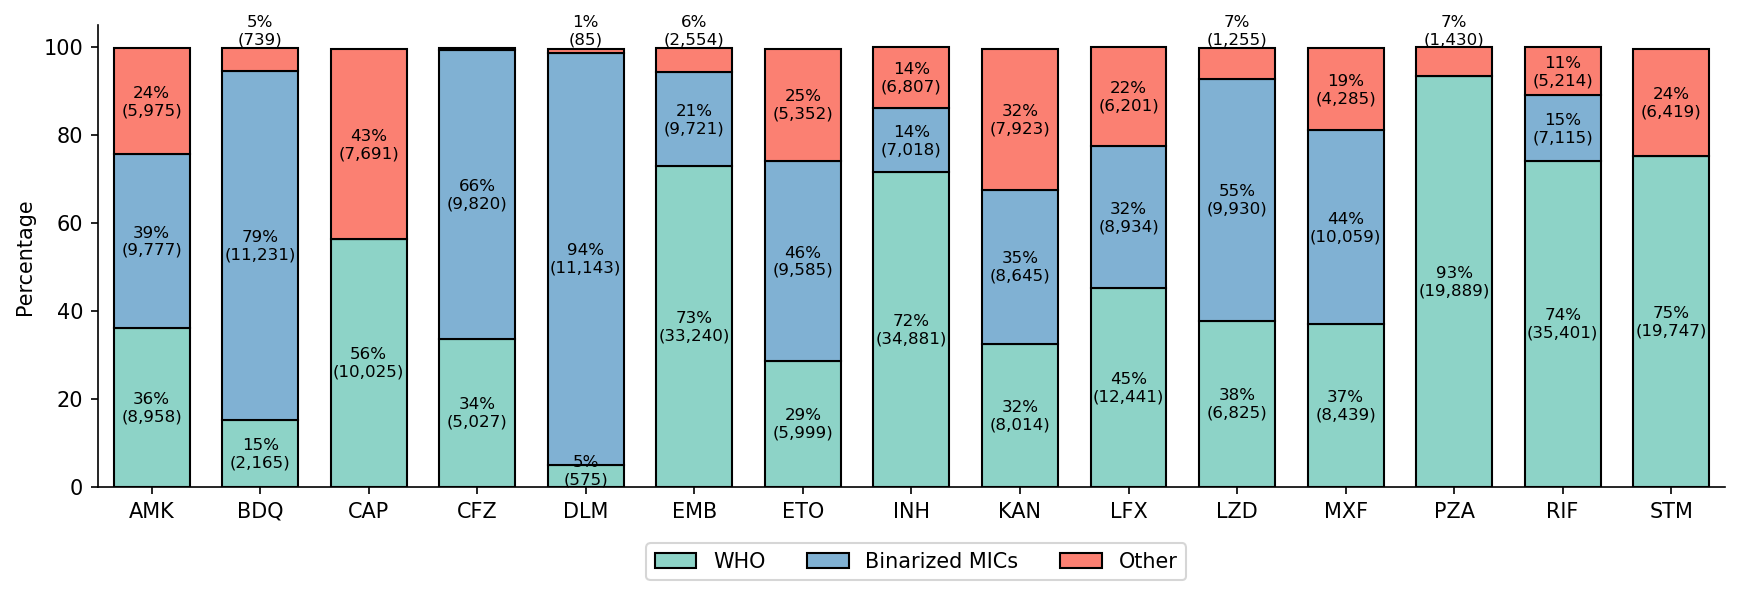

In [35]:
samples_summary_for_plotting_percent = pd.read_csv("../tables/ALL_phenos_breakdown_percents.csv", index_col=[0])

# Plotting
bar_width=0.7
fig, ax = plt.subplots(figsize=(14, 4))

# for 3 groups
colors = [sns.color_palette('Set3')[0]] + [sns.color_palette('Set3')[4]] + [sns.color_palette('Set3')[3]]
groups_dict = {'WHO_Phenos': 'WHO', 'ALL_MIC': 'Binarized MICs', 'ALL_not_MIC': 'Other'}

prev_vals = np.zeros(samples_summary_for_plotting_percent.shape[0])

for i, group in enumerate(samples_summary_for_plotting_percent.columns):
    
    ax.bar([drug_abbr_dict[drug] for drug in samples_summary_for_plotting_percent.index.values], samples_summary_for_plotting_percent[group], width=bar_width, bottom=prev_vals, label=groups_dict[group], color=colors[i], edgecolor='black')

    prev_vals += samples_summary_for_plotting_percent[group]


for drug in np.sort(samples_summary_for_plotting_percent.index.values):

    for col_idx, col in enumerate(samples_summary_for_plotting_percent.columns):

        val = int(np.round(samples_summary_for_plotting_percent.loc[drug, col], 0))

        # top of the current box
        y_upper = samples_summary_for_plotting_percent.loc[drug, samples_summary_for_plotting_percent.columns[:col_idx + 1]].values.sum()
        
        # bottom of the current box
        y_lower = samples_summary_for_plotting_percent.loc[drug, samples_summary_for_plotting_percent.columns[:col_idx]].values.sum()
        
        y_pos = np.mean([y_lower, y_upper])

        if val > 0:
            # format with commas and don't include any decimal places
            comma_format = '{:,.0f}'.format(samples_summary_for_plotting.loc[drug, col])
            combined_text = f"{val}%\n({comma_format})"

            # small numbers for which the bars are too short to accommodate the whole number, put on top
            if val < 10:

                # top bar: make y_pos = 100
                if col_idx == samples_summary_for_plotting_percent.shape[1] - 1:
                    ax.text(drug_abbr_dict[drug], 100, combined_text, ha='center', va='bottom', fontsize='8')
                # bottom bar: make y_pos = 0
                elif col_idx == 0:
                    ax.text(drug_abbr_dict[drug], 0, combined_text, ha='center', va='bottom', fontsize='8')
                # else, idk
                else:
                    ax.text(drug_abbr_dict[drug], y_pos, combined_text, ha='center', va='bottom', fontsize='8')
            else:
                ax.text(drug_abbr_dict[drug], y_pos, combined_text, ha='center', va='center', fontsize='8')


ax.margins(x=0.01)
ax.set_ylabel("Percentage")
# plt.title("Percentages and Counts of Phenotypic Subgroups of ALL Datasets\n")
sns.despine()
plt.legend()

sns.move_legend(ax, fontsize=10, title='', loc='upper right', #bbox_to_anchor=(1.05, 0.65),
                ncol=len(colors),
               bbox_to_anchor=(0.675, -0.1))

plt.savefig("../results/Figures/ALL_phenos_subgroups.svg", format='svg', bbox_inches='tight')

# Bedaquiline Skew between WHO and ALL Datasets

In [41]:
drug = "Bedaquiline"
df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
df_phenos = df_phenos.merge(lineages, left_on='sample_id', right_on='Sample_ID', how='left')

who_model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))
all_model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=ALL/dropAF_noSyn_unpooled/model_matrix.pkl"))

df_WHO = df_phenos.query("sample_id in @who_model_matrix.index.values & ~Lineage.str.contains(',')")
df_ALL = df_phenos.query("sample_id in @all_model_matrix.index.values & ~Lineage.str.contains(',')")
print(len(df_WHO), len(df_ALL))

2000 13761


In [42]:
df_WHO_lineage_phenos = pd.DataFrame(df_WHO.groupby("Lineage").phenotype.mean()).reset_index()
df_WHO_lineage_phenos.loc[-1, :] = ['Total', df_WHO.phenotype.mean()]
df_WHO_lineage_phenos['Dataset'] = 'WHO'

df_ALL_lineage_phenos = pd.DataFrame(df_ALL.groupby("Lineage").phenotype.mean()).reset_index()
df_ALL_lineage_phenos.loc[-1, :] = ['Total', df_ALL.phenotype.mean()]
df_ALL_lineage_phenos['Dataset'] = 'ALL'

lineage_phenos_combined = pd.concat([df_WHO_lineage_phenos, df_ALL_lineage_phenos])
lineage_phenos_combined['phenotype'] *= 100
print(len(set(df_WHO.sample_id).intersection(df_ALL.sample_id)))

2000


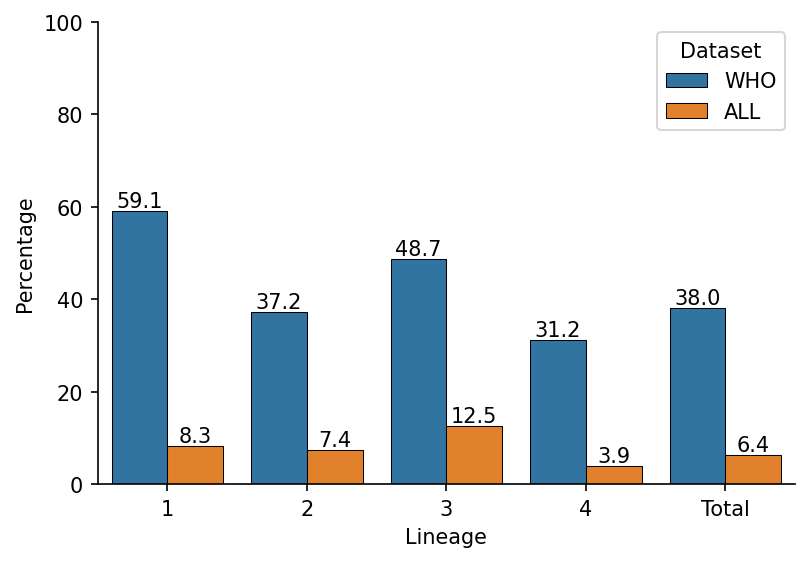

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(data=lineage_phenos_combined.query("phenotype > 0"),
            x='Lineage',
            y='phenotype',
            hue='Dataset',
            edgecolor='black',
            linewidth=0.5,
            ax=ax
           )

for container in ax.containers:
    ax.bar_label(container, fmt='{:.1f}')

plt.ylabel("Percentage")
# plt.title("Percentage of Bedaquiline-Resistant Samples by Lineage and Dataset", size=10)
plt.ylim(0, 100)
sns.despine()
plt.savefig("../results/Figures/BDQ_phenos_by_lineage_dataset.svg", format='svg', bbox_inches='tight')

In [44]:
mic_model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "MIC/tiers=1/dropAF_noSyn_unpooled/model_matrix.pkl"))
df_mic = pd.read_csv(os.path.join(analysis_dir, 'Bedaquiline', "phenos_mic.csv"))

# first apply the media hierarchy to decide which of the measured MICs to keep for each isolate (for isolates with multiple MICs measured in different media)
df_mic = process_multiple_MICs_different_media(df_mic)

# then normalize the MICs to the most common medium. This creates a new column: norm_MIC that should be used if not Pretomanid
pheno_col = 'norm_MIC'
df_mic, most_common_medium = normalize_MICs_return_dataframe(drug, df_mic, cc_df)
print(f"    Min MIC: {np.min(df_mic[pheno_col].values)}, Max MIC: {np.max(df_mic[pheno_col].values)} in {most_common_medium}")

mic_model_matrix = mic_model_matrix.merge(df_mic, left_index=True, right_on='sample_id', how='left')

    Dropped 58/12646 isolates in ['7H10', '7H9', 'Frozen Broth Microdilution Plate (PMID31969421)', 'M24 BMD'] without critical concentrations
    Min MIC: 0.00375, Max MIC: 2.0 in UKMYC5


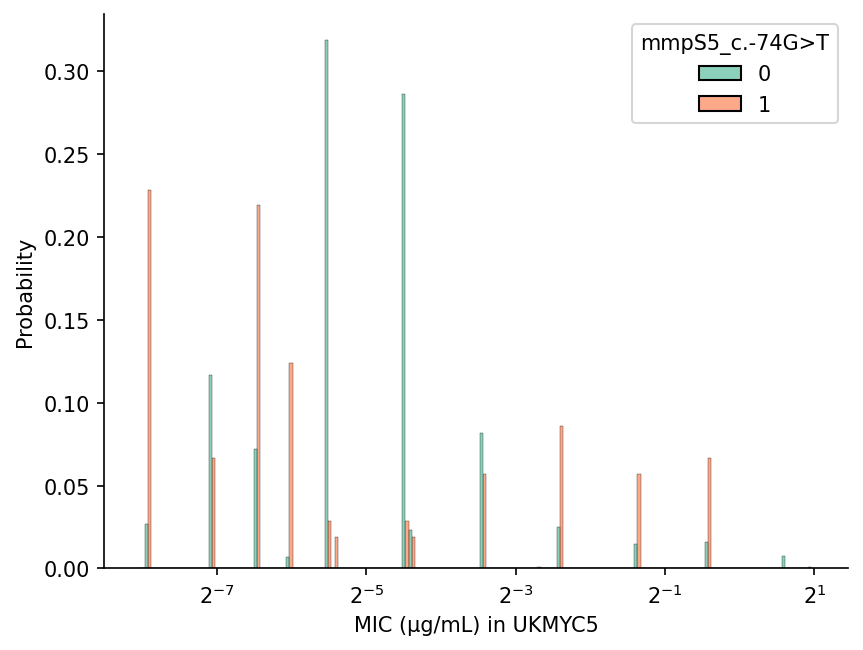

In [45]:
mic_model_matrix['mmpS5_c.-74G>T'] = mic_model_matrix['mmpS5_c.-74G>T'].astype(int)

sns.histplot(data=mic_model_matrix,
             x='norm_MIC',
             log_scale=2,
             hue='mmpS5_c.-74G>T',
             palette='Set2',
             common_norm=False,
             multiple='dodge',
             stat='probability',
            )

plt.xlabel(f'MIC (µg/mL) in {most_common_medium}')
sns.despine()
plt.savefig("../results/Figures/BDQ_MICs_mmpS5.svg", format='svg', dpi=300)

# MIC Distributions across isolates +/- mmpS5 and other Group 1-3 Variants

1. mmpS5 + another Group 1-2 variant
2. mmpS5 + Group 3 variant
3. mmpS5 + 3 lineage markers (and other Group 5 variants)
  
Was this explored with the MIC data by tabulating the mode of MICs in this group versus those that were graded as R with a mutation?

In [7]:
BDQ_genos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "genos_1.csv.gz"), compression='gzip', usecols=['sample_id', 'resolved_symbol', 'variant_category', 'variant_allele_frequency'])

BDQ_phenos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_binary.csv"))

BDQ_genos['mutation'] = BDQ_genos['resolved_symbol'] + '_' + BDQ_genos['variant_category']

del BDQ_genos['resolved_symbol']
del BDQ_genos['variant_category']

In [8]:
search_variant = 'mmpS5_c.-74G>T'

# get only those in the ALL model matrix too
isolates_with_variant = BDQ_genos.query("mutation==@search_variant & variant_allele_frequency > 0.75 & sample_id in @all_model_matrix.index.values")['sample_id'].unique()
R_isolates_with_variant = BDQ_phenos.query("sample_id in @isolates_with_variant & phenotype==1")['sample_id'].unique()

print(f"{len(isolates_with_variant)} isolates have {search_variant}")
print(f"{len(R_isolates_with_variant)} BDQ-R isolates have {search_variant}")

120 isolates have mmpS5_c.-74G>T
31 BDQ-R isolates have mmpS5_c.-74G>T


In [9]:
exclude_variants = [search_variant, 'mmpL5_p.Asp767Asn', 'mmpL5_p.Thr794Ile', 'mmpL5_p.Ile948Val']

# isolates_with_other_variants = BDQ_genos.query("sample_id in @isolates_with_variant & mutation not in @exclude_variants & variant_allele_frequency > 0.75")['sample_id'].values
R_isolates_with_other_variants = BDQ_genos.query("sample_id in @R_isolates_with_variant & mutation not in @exclude_variants & variant_allele_frequency > 0.75")['sample_id'].unique()

R_isolates_no_other_variants = list(set(R_isolates_with_variant) - set(R_isolates_with_other_variants))

print(f"{len(R_isolates_with_other_variants)} BDQ-R isolates have other variants")
print(f"{len(R_isolates_no_other_variants)} BDQ-R isolates have no other variants")

15 BDQ-R isolates have other variants
16 BDQ-R isolates have no other variants


In [10]:
# all 31 isolates with mmpS5_c.-74G>T have the three lineage markers in mmpL5
BDQ_genos.query("sample_id in @R_isolates_with_variant & variant_allele_frequency > 0.75 & mutation != @search_variant").merge(who_variants.query("drug=='Bedaquiline'")[['variant', 'INITIAL CONFIDENCE GRADING', 'FINAL CONFIDENCE GRADING']], left_on='mutation', right_on='variant')[['mutation', 'INITIAL CONFIDENCE GRADING', 'FINAL CONFIDENCE GRADING']].value_counts()

mutation           INITIAL CONFIDENCE GRADING  FINAL CONFIDENCE GRADING  
mmpL5_p.Asp767Asn  5) Not assoc w R            5) Not assoc w R              31
mmpL5_p.Ile948Val  5) Not assoc w R            4) Not assoc w R - Interim    31
mmpL5_p.Thr794Ile  5) Not assoc w R            4) Not assoc w R - Interim    31
Rv0678_p.Asp47fs   1) Assoc w R                1) Assoc w R                   3
Rv0678_p.Glu49fs   1) Assoc w R                1) Assoc w R                   3
atpE_p.Ile66Met    1) Assoc w R                2) Assoc w R - Interim         3
Rv0678_p.Cys46Arg  1) Assoc w R                2) Assoc w R - Interim         2
Rv0678_p.Gln115*   3) Uncertain significance   2) Assoc w R - Interim         1
Rv0678_p.Leu60Pro  3) Uncertain significance   3) Uncertain significance      1
Rv0678_p.Pro48fs   1) Assoc w R                2) Assoc w R - Interim         1
Rv0678_p.Thr69fs   3) Uncertain significance   2) Assoc w R - Interim         1
Rv0678_p.Tyr145fs  3) Uncertain significance  

In [11]:
R_isolates_with_variant_annot = BDQ_genos.query("sample_id in @R_isolates_with_variant & variant_allele_frequency > 0.75 & mutation != @search_variant").merge(who_variants.query("drug=='Bedaquiline'")[['variant', 'INITIAL CONFIDENCE GRADING', 'FINAL CONFIDENCE GRADING']], left_on='mutation', right_on='variant')

# 11 isolates have one of 5 Group 1-2 variants by SOLO - GR, 14 isolates have one of 5 Group 1-2 variants by SOLO + GR
R_isolates_with_variant_annot.loc[R_isolates_with_variant_annot['INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R')].sample_id.nunique(), R_isolates_with_variant_annot.loc[R_isolates_with_variant_annot['FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].sample_id.nunique()

(11, 14)

In [21]:
R_isolates_with_variant_annot.loc[~R_isolates_with_variant_annot['INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("mutation not in @exclude_variants").sample_id.nunique(), R_isolates_with_variant_annot.loc[~R_isolates_with_variant_annot['FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("mutation not in @exclude_variants").sample_id.nunique()

(4, 1)

In [20]:
R_isolates_with_Group12_variants = R_isolates_with_variant_annot.loc[R_isolates_with_variant_annot['INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R')].sample_id.unique()

R_isolates_with_Group3_variants = R_isolates_with_variant_annot.loc[~R_isolates_with_variant_annot['INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("mutation not in @exclude_variants").sample_id.unique()

len(R_isolates_with_Group12_variants), len(R_isolates_with_Group3_variants), len(R_isolates_no_other_variants)

(11, 4, 16)

In [42]:
len(df_mic.query("sample_id in @R_isolates_with_Group12_variants")), len(df_mic.query("sample_id in @R_isolates_with_Group3_variants")), len(df_mic.query("sample_id in @R_isolates_no_other_variants"))

(7, 2, 10)

In [24]:
df_mic.query("sample_id in @R_isolates_with_Group12_variants")['norm_MIC'].median(), df_mic.query("sample_id in @R_isolates_with_Group3_variants")['norm_MIC'].median(), df_mic.query("sample_id in @R_isolates_no_other_variants")['norm_MIC'].median()

(0.375, 0.1171875, 0.375)

In [40]:
0.375/0.1171875

3.2

In [38]:
df_mic.query("sample_id in @R_isolates_with_Group12_variants")['mic_value'].median(), df_mic.query("sample_id in @R_isolates_with_Group3_variants")['mic_value'].median(), df_mic.query("sample_id in @R_isolates_no_other_variants")['mic_value'].median()

(1.5, 0.46875, 1.5)

In [41]:
df_mic.query("sample_id in @R_isolates_with_Group3_variants")

,sample_id,medium,MIC_lower,MIC_upper,Lower_bracket,Upper_bracket,mic_value,medium_CC,norm_medium,norm_MIC
395,823381,MGIT,0.125,0.25,(,],0.1875,1.0,UKMYC5,0.046875
790,823314,MGIT,0.500,1.00,(,],0.7500,1.0,UKMYC5,0.187500


In [39]:
1.5/0.46875

3.2

In [31]:
df_mic.query("sample_id in @R_isolates_with_Group3_variants")

,sample_id,medium,MIC_lower,MIC_upper,Lower_bracket,Upper_bracket,mic_value,medium_CC,norm_medium,norm_MIC
395,823381,MGIT,0.125,0.25,(,],0.1875,1.0,UKMYC5,0.046875
790,823314,MGIT,0.500,1.00,(,],0.7500,1.0,UKMYC5,0.187500


In [29]:
df_mic.query("sample_id in @R_isolates_no_other_variants")

,sample_id,medium,MIC_lower,MIC_upper,Lower_bracket,Upper_bracket,mic_value,medium_CC,norm_medium,norm_MIC
221,823014,MGIT,1.0,2.0,(,],1.50,1.0,UKMYC5,0.3750
394,823202,MGIT,0.5,1.0,(,],0.75,1.0,UKMYC5,0.1875
430,823350,MGIT,1.0,2.0,(,],1.50,1.0,UKMYC5,0.3750
656,822966,MGIT,0.5,1.0,(,],0.75,1.0,UKMYC5,0.1875
927,823384,MGIT,2.0,4.0,(,],3.00,1.0,UKMYC5,0.7500
994,823072,MGIT,2.0,4.0,(,],3.00,1.0,UKMYC5,0.7500
1047,823323,MGIT,2.0,4.0,(,],3.00,1.0,UKMYC5,0.7500
1057,823201,MGIT,0.5,1.0,(,],0.75,1.0,UKMYC5,0.1875
1143,823403,MGIT,2.0,4.0,(,],3.00,1.0,UKMYC5,0.7500
1303,822974,MGIT,1.0,2.0,(,],1.50,1.0,UKMYC5,0.3750


In [28]:
BDQ_genos.query("sample_id in @R_isolates_no_other_variants & variant_allele_frequency > 0.75 & mutation != @search_variant").mutation.unique()

array(['mmpL5_p.Ile948Val', 'mmpL5_p.Thr794Ile', 'mmpL5_p.Asp767Asn'],
      dtype=object)

In [44]:
who_variants.query("variant in ['mmpL5_p.Ile948Val', 'mmpL5_p.Thr794Ile', 'mmpL5_p.Asp767Asn'] & drug=='Bedaquiline'")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
1268,Bedaquiline,mmpL5,p.Asp767Asn,mmpL5_p.Asp767Asn,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",0.0,0.0,0.0,...,NaN,5) Not assoc w R,NaN,No change,NaN,NaN,yes,NaN,NaN,1
1331,Bedaquiline,mmpL5,p.Ile948Val,mmpL5_p.Ile948Val,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",1.0,5468.0,55.0,...,Literature evidence (PMID 28031270; 34503982),4) Not assoc w R - Interim,NaN,DOWN from NotAwR to NotAwRI,NaN,NaN,yes,Lit. (PMID 28031270; 34503982),NaN,3
1412,Bedaquiline,mmpL5,p.Thr794Ile,mmpL5_p.Thr794Ile,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",1.0,4.0,0.0,...,Literature evidence (PMID 28031270; 34503982),4) Not assoc w R - Interim,NaN,DOWN from NotAwR to NotAwRI,NaN,NaN,yes,Lit. (PMID 28031270; 34503982),NaN,3


# S95T Distribution Across MXF and LXF Isolates

In [117]:
def get_all_data_single_drug(drug):

    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    df_genos = pd.read_csv(os.path.join(analysis_dir, drug, "genos_1.csv.gz"), compression='gzip', usecols=['sample_id', 'resolved_symbol', 'variant_category', 'variant_allele_frequency'])
    
    df_genos['mutation'] = df_genos['resolved_symbol'] + '_' + df_genos['variant_category']
    del df_genos['resolved_symbol']
    del df_genos['variant_category']

    df_MIC = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_mic.csv"))
    pheno_col = "norm_MIC"
    
    # first apply the media hierarchy to decide which of the measured MICs to keep for each isolate (for isolates with multiple MICs measured in different media)
    df_MIC = process_multiple_MICs_different_media(df_MIC)
    
    # then normalize the MICs to the most common medium. This creates a new column: norm_MIC that should be used if not Pretomanid
    df_MIC, most_common_medium = normalize_MICs_return_dataframe(drug, df_MIC, cc_df)
    print(f"    Min MIC: {np.min(df_MIC[pheno_col].values)}, Max MIC: {np.max(df_MIC[pheno_col].values)} in {most_common_medium}")

    return df_phenos, df_genos, df_MIC

In [118]:
MXF_phenos, MXF_genos, MXF_MIC = get_all_data_single_drug('Moxifloxacin')
LEV_phenos, LEV_genos, LEV_MIC = get_all_data_single_drug('Levofloxacin')

    Dropped 97/12740 isolates in ['7H9', 'Frozen Broth Microdilution Plate (PMID31969421)', 'REMA', 'M24 BMD'] without critical concentrations
    Min MIC: 0.03, Max MIC: 20.0 in UKMYC5
    Dropped 60/11434 isolates in ['7H9', 'Frozen Broth Microdilution Plate (PMID31969421)', 'M24 BMD'] without critical concentrations
    Min MIC: 0.06, Max MIC: 8.0 in UKMYC5


In [134]:
def get_data_isolates_with_without_variant(variant, df_genos):

    isolates_with_var = df_genos.query("mutation==@variant & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_without_var = list(set(df_genos.sample_id) - set(isolates_with_var))
    
    print(f"{len(isolates_with_var)} isolates with {variant}, {len(isolates_without_var)} isolates without it")

    isolates_with_other_vars = df_genos.query("sample_id in @isolates_with_var & mutation != @variant & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_with_no_other_vars = list(set(isolates_with_var) - set(isolates_with_other_vars))
    
    # check that the only variant in these isolates is S95T
    assert len(df_genos.query("sample_id in @isolates_with_no_other_vars & variant_allele_frequency > 0.75").mutation.unique()) == 1
    assert df_genos.query("sample_id in @isolates_with_no_other_vars & variant_allele_frequency > 0.75").mutation.unique()[0] == variant
    
    isolates_with_something = df_genos.query("sample_id in @isolates_without_var & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_with_nothing = list(set(isolates_without_var) - set(isolates_with_something))
    
    # check that there are no variants in these isolates
    assert len(df_genos.query("sample_id in @isolates_with_nothing & variant_allele_frequency > 0.75")) == 0
    
    print(f"{len(isolates_with_no_other_vars)} isolates with only {variant}, {len(isolates_with_nothing)} isolates with no variants at all\n")

    # add in lineage information to plot distribution of isolates across lineages, stratified by presence/absence of the variant
    df_with_lineages = lineages.query("Sample_ID in @isolates_with_no_other_vars")[['Sample_ID', 'Coll2014', 'Lineage']]
    df_with_lineages[variant] = 1
    
    df_with_lineages = pd.concat([df_with_lineages, lineages.query("Sample_ID in @isolates_with_nothing")[['Sample_ID', 'Coll2014', 'Lineage']]])
    df_with_lineages[variant] = df_with_lineages[variant].fillna(0).astype(int)

    # exclude isolates with multiple lineages
    df_1 = lineages.query("Sample_ID in @isolates_with_no_other_vars & ~Lineage.str.contains(',')")[['Sample_ID', 'Lineage']].groupby("Lineage")['Sample_ID'].count().reset_index().rename(columns={'Sample_ID': 'Count'})
    df_1[variant] = 1
    
    df_2 = lineages.query("Sample_ID in @isolates_with_nothing & ~Lineage.str.contains(',')")[['Sample_ID', 'Lineage']].groupby("Lineage")['Sample_ID'].count().reset_index().rename(columns={'Sample_ID': 'Count'})
    df_2[variant] = 0
    
    df_lineages_summary = pd.concat([df_1, df_2])
    
    # make sure all lineages are there for both groups. If not, fill with 0s
    for lineage in df_lineages_summary.Lineage.unique():
    
        if len(df_lineages_summary.loc[df_lineages_summary[variant]==1].query("Lineage==@lineage")) == 0:
            df_lineages_summary = pd.concat([df_lineages_summary, pd.DataFrame({'Lineage': lineage, 'Count': 0, variant: 1}, index=[-1])])
    
        if len(df_lineages_summary.loc[df_lineages_summary[variant]==0].query("Lineage==@lineage")) == 0:
            df_lineages_summary = pd.concat([df_lineages_summary, pd.DataFrame({'Lineage': lineage, 'Count': 0, variant: 0}, index=[-1])])
    
    df_lineages_summary = df_lineages_summary.reset_index(drop=True)
    
    df_lineages_summary['Lineage_Total'] = df_lineages_summary['Lineage'].map(dict(df_lineages_summary.groupby('Lineage')['Count'].sum()))
    df_lineages_summary['Lineage_Percentage'] = df_lineages_summary['Count'] / df_lineages_summary['Lineage_Total'] * 100
    
    df_lineages_summary['Var_Total'] = df_lineages_summary[variant].map(dict(df_lineages_summary.groupby(variant)['Count'].sum()))
    df_lineages_summary['Var_Percentage'] = df_lineages_summary['Count'] / df_lineages_summary['Var_Total'] * 100
    
    df_lineages_summary = df_lineages_summary.sort_values([variant, "Lineage"], ascending=[True, False])
    return df_lineages_summary

In [135]:
variant = 'gyrA_p.Ser95Thr'
MXF_lineages_summary = get_data_isolates_with_without_variant(variant, MXF_genos)
LEV_lineages_summary = get_data_isolates_with_without_variant(variant, LEV_genos)

20903 isolates with gyrA_p.Ser95Thr, 1880 isolates without it
17 isolates with only gyrA_p.Ser95Thr, 37 isolates with no variants at all

24965 isolates with gyrA_p.Ser95Thr, 2611 isolates without it
23 isolates with only gyrA_p.Ser95Thr, 44 isolates with no variants at all



In [241]:
def plot_lineage_distribution_by_variant(variant, df_lineages_summary, drug, save=False):

    fig, ax = plt.subplots(figsize=(3.5, 5))
    
    LinToColor_Dict = {"1": "#f381b2",
                       "2": "#006dbb",
                       "3": "#9f5eab",
                       "4": "#f6472b",
                       "5": "#76400e",
                       "6": "#36ba74",
                       "7": "#ffb000",
                       "BOV": "gray",
                       "BOV_AFRI": "black",
                      }
    
    #lineages_lst = np.sort(MXF_lineages_summary.Lineage.unique())
    groups = [f'- {variant}', f'+ {variant}']

    lineages_lst = df_lineages_summary.Lineage.unique()
    df_lineages_summary = df_lineages_summary.set_index('Lineage')
    
    group_totals = np.zeros(len(groups))
    
    for i, lineage in enumerate(lineages_lst):
    
        ax.bar(groups, 
               height=df_lineages_summary.loc[lineage, 'Var_Percentage'], 
               bottom=group_totals, 
               color=LinToColor_Dict[lineage], 
               edgecolor='black', 
               # linewidth=0.5, 
               label=lineage, 
               alpha=0.75
              )
    
        group_totals += df_lineages_summary.loc[lineage, 'Var_Percentage'].values
    
        # ax.bar_label(container=ax.containers[i], labels=[np.round(val.get_height(), 1) if val.get_height() > 0 else "" for val in ax.containers[i]], fmt='{:.1f}', label_type='center', fontsize='11')
    
        # annotate with percentage and counts
        for group in [0, 1]:

            val = int(np.round(df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineage, 'Var_Percentage'], 0))

            if val > 0:
                # bottom of the current box
                y_upper = df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineages_lst[:i+1], 'Var_Percentage'].values.sum()
                y_lower = df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineages_lst[:i], 'Var_Percentage'].values.sum()
    
                y_pos = np.mean([y_lower, y_upper])
            
                # format the isolate counts with commas and don't include any decimal places
                var_lineage_count = '{:,.0f}'.format(df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineage, 'Count'])
                combined_text = f"{val}% ({var_lineage_count})"
                ax.text(group, y_pos, combined_text, ha='center', va='center', fontsize='9')
        
    bar_scale = 0.8
    # for patch in ax.patches:
    #     current_width = patch.get_width()
    #     patch.set_width(current_width * bar_scale)
    
    for patch in ax.patches:
        current_width = patch.get_width()
        new_width = current_width * bar_scale
        # Adjusting the x coordinate to center the bar
        diff_width = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff_width / 2)
    
    plt.setp(ax.patches, linewidth=0.75)
    plt.legend()
    
    # Rearrange the handles and labels
    handles, labels = ax.get_legend_handles_labels()    
    handles_labels_dict = dict(zip(labels, handles))
    handles_labels_dict = collections.OrderedDict(sorted(handles_labels_dict.items()))
    
    ax.legend(list(handles_labels_dict.values()), list(handles_labels_dict.keys()))
    
    sns.move_legend(ax, 
                    ncols=len(lineages_lst), 
                    fontsize=7, title='Lineage', loc='best', 
                    bbox_to_anchor=(0.86, -0.08)
                   )
    plt.xlabel('')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel('Percentage')
    plt.title(f'Lineage Distribution of {df_lineages_summary.Count.sum()} {drug} Samples\n')
    
    sns.despine()

    if not save:
        plt.show()
    else:
        plt.savefig(f"../results/Figures/{drug}_MICs_S95T_lineage.png", dpi=300, bbox_inches='tight')

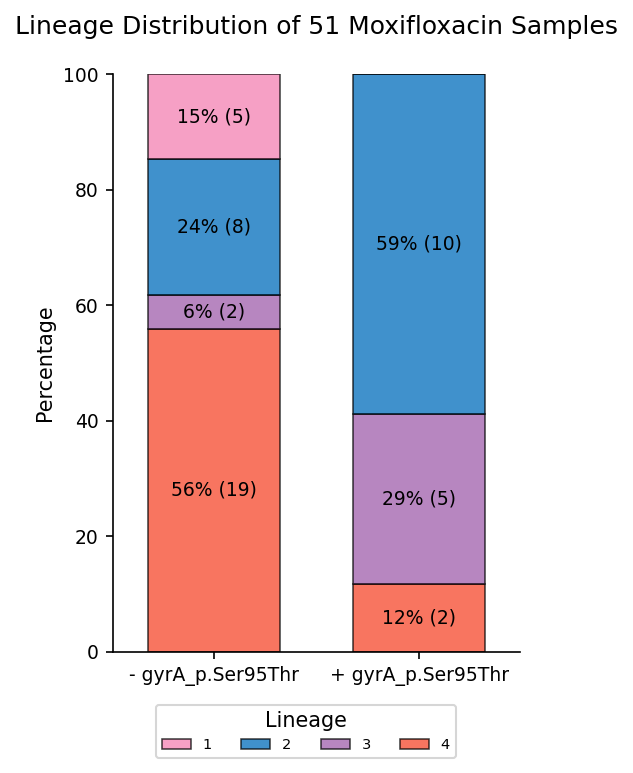

In [242]:
plot_lineage_distribution_by_variant(variant, MXF_lineages_summary, 'Moxifloxacin', save=True)

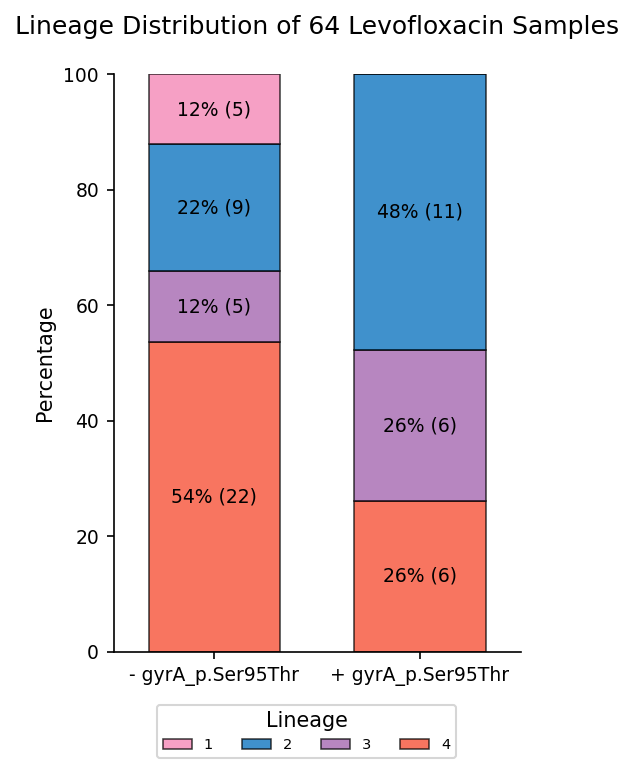

In [243]:
plot_lineage_distribution_by_variant(variant, LEV_lineages_summary, 'Levofloxacin', save=True)

In [236]:
def plot_MIC_ECDF_by_variant(variant, df_genos, df_MIC, drug, save=False):

    isolates_with_var = df_genos.query("mutation==@variant & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_without_var = list(set(df_genos.sample_id) - set(isolates_with_var))
    
    print(f"{len(isolates_with_var)} isolates with {variant}, {len(isolates_without_var)} isolates without it")

    df_MIC.loc[df_MIC['sample_id'].isin(isolates_with_var), variant] = 1
    df_MIC.loc[df_MIC['sample_id'].isin(isolates_without_var), variant] = 0
    
    assert len(df_MIC.loc[pd.isnull(df_MIC[variant])]) == 0
    df_MIC[variant] = df_MIC[variant].astype(int)
    df_MIC.groupby(variant)['norm_MIC'].mean()

    fig, ax = plt.subplots()
    
    sns.ecdfplot(data=df_MIC,
                 x='norm_MIC',
                 hue=variant,
                 log_scale=2,
                 palette='Set2',
                 ax=ax
                )
    
    plt.title(f"{len(df_MIC)} {drug} MICs")
    plt.xlabel(f"MIC (µg/mL) in UKMYC5")

    plt.ylabel("Percentile")
    plt.yticks(ticks=ax.get_yticks(), labels=(ax.get_yticks()*100).astype(int))
    sns.move_legend(ax, loc='lower right')
    
    sns.despine()
    
    if not save:
        plt.show()
    else:
        plt.savefig(f"../results/Figures/{drug}_MICs_S95T.png", dpi=300, bbox_inches='tight')

20903 isolates with gyrA_p.Ser95Thr, 1880 isolates without it


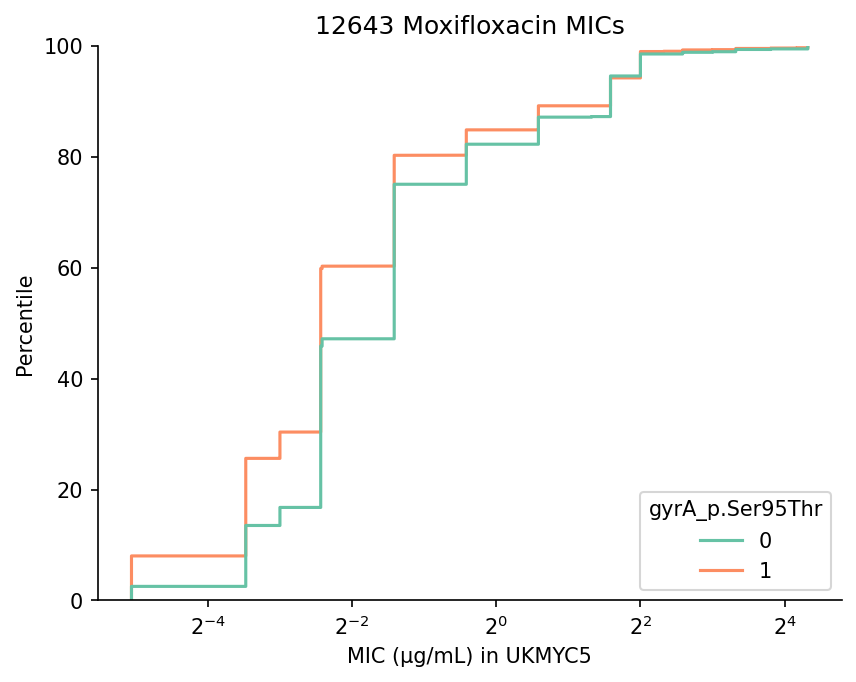

In [237]:
plot_MIC_ECDF_by_variant(variant, MXF_genos, MXF_MIC, 'Moxifloxacin', save=True)

24965 isolates with gyrA_p.Ser95Thr, 2611 isolates without it


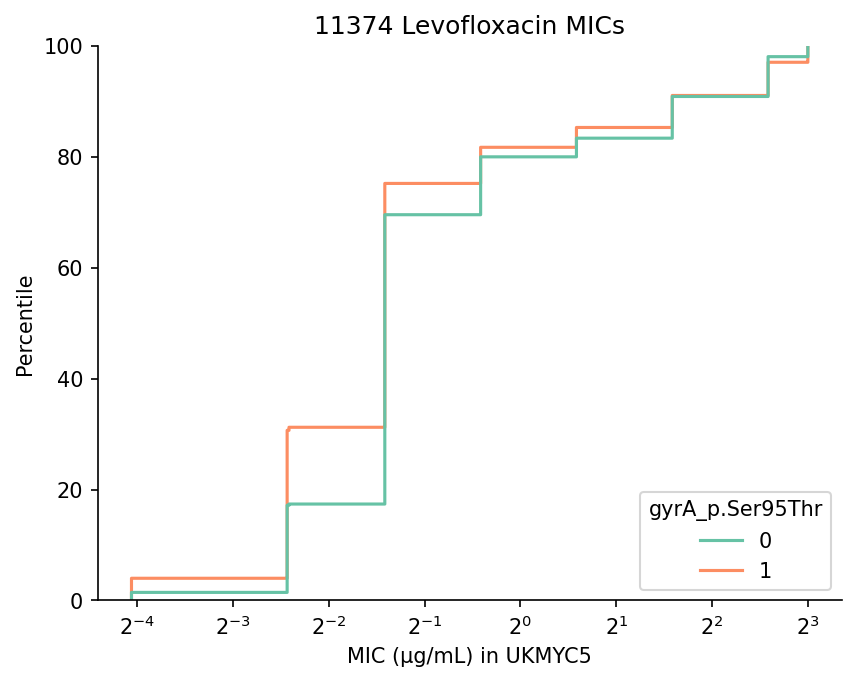

In [238]:
plot_MIC_ECDF_by_variant(variant, LEV_genos, LEV_MIC, 'Levofloxacin', save=True)